In [7]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tf2onnx
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Dataset

In [8]:
# !wget -O dataset.zip https://chmura.put.poznan.pl/s/LxYSsota5PCbXcU/download
# !mkdir dataset_jetbot
# !unzip dataset.zip
# !rm dataset/1652875851.3497071/0199.jpg

In [9]:
def preprocess_image(img):
    img = cv2.resize(img, (64, 64))
    return np.array(img).astype(np.float32) / 255

In [10]:
def create_dataset(img_folder):
    X, y = [], []
    for dir1 in os.listdir(img_folder):
        if '.csv' not in dir1:
            csv = pd.read_csv(os.path.join(img_folder, dir1 + '.csv'), sep=',', header=None)
            for row in csv.iterrows():
                y.append((row[1][1], row[1][2]))
            for file in sorted(os.listdir(os.path.join(img_folder, dir1))):
                image = cv2.imread(os.path.join(img_folder, dir1, file), cv2.COLOR_BGR2RGB)
                X.append(preprocess_image(image))

    return np.array(X), np.array(y)

In [11]:
X, y = create_dataset('./dataset/')
X.shape, y.shape

((7584, 64, 64, 3), (7584, 2))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=23)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5308, 64, 64, 3), (2276, 64, 64, 3), (5308, 2), (2276, 2))

### Augmentation

[0.6875    0.9921875]


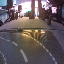

In [19]:
print(y[72])
Image.fromarray(np.array(X[72] * 255).astype(np.uint8))

In [20]:
def brightness_augment(img):
    img = np.array(img * 255).astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 2] = hsv[:, :, 2] * (np.random.normal(1.0, 0.6))
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
    hsv[:, :, 2][hsv[:, :, 2] < 0] = 0
    rgb = cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2RGB)
    return rgb.astype(np.float32) / 255

[0.6875    0.9921875]


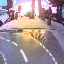

In [21]:
print(y[72])
Image.fromarray(np.array(brightness_augment(X[72]) * 255).astype(np.uint8))

In [22]:
def flip_augment(img):
    return cv2.flip(img, 1)

def flip_label(label):
    return (label[0], -label[1])

(0.6875, -0.9921875)


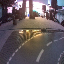

In [23]:
print(flip_label(y[72]))
Image.fromarray(np.array(flip_augment(X[72]) * 255).astype(np.uint8))

In [24]:
X_aug, y_aug = [], []
for xi, yi in zip(X_train, y_train):
    bright1 = brightness_augment(xi)
    bright2 = brightness_augment(xi)
    flip1 = flip_augment(xi)
    flip2 = flip_augment(bright1)
    flip3 = flip_augment(bright2)

    X_aug.append(bright1)
    y_aug.append(yi)
    X_aug.append(bright2)
    y_aug.append(yi)
    X_aug.append(flip1)
    y_aug.append(flip_label(yi))
    X_aug.append(flip2)
    y_aug.append(flip_label(yi))
    X_aug.append(flip3)
    y_aug.append(flip_label(yi))

X_aug, y_aug = np.array(X_aug), np.array(y_aug)
X_aug.shape, y_aug.shape

((26540, 64, 64, 3), (26540, 2))

In [25]:
X_train, y_train = np.concatenate([X_train, X_aug]), np.concatenate([y_train, y_aug])
X_train, y_train = shuffle((X_train, y_train), random_state=23)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31848, 64, 64, 3), (2276, 64, 64, 3), (31848, 2), (2276, 2))

### Model

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='tanh')
])

In [27]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=7, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=3, min_lr=0.001)
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
996/996 [==============================] - 50s 49ms/step - loss: 0.1848 - mae: 0.2787 - val_loss: 0.1294 - val_mae: 0.2535 - lr: 0.1000
Epoch 2/100
996/996 [==============================] - 52s 52ms/step - loss: 0.1241 - mae: 0.2207 - val_loss: 0.1004 - val_mae: 0.1949 - lr: 0.1000
Epoch 3/100
996/996 [==============================] - 54s 54ms/step - loss: 0.1158 - mae: 0.2105 - val_loss: 0.0936 - val_mae: 0.1864 - lr: 0.1000
Epoch 4/100
996/996 [==============================] - 53s 54ms/step - loss: 0.1094 - mae: 0.2032 - val_loss: 0.0898 - val_mae: 0.1846 - lr: 0.1000
Epoch 5/100
996/996 [==============================] - 55s 55ms/step - loss: 0.1051 - mae: 0.2002 - val_loss: 0.0950 - val_mae: 0.1934 - lr: 0.1000
Epoch 6/100
996/996 [==============================] - 55s 55ms/step - loss: 0.1005 - mae: 0.1943 - val_loss: 0.0881 - val_mae: 0.1807 - lr: 0.1000
Epoch 7/100
996/996 [==============================] - 54s 54ms/step - loss: 0.0973 - mae: 0.1907 - val_loss: 0.

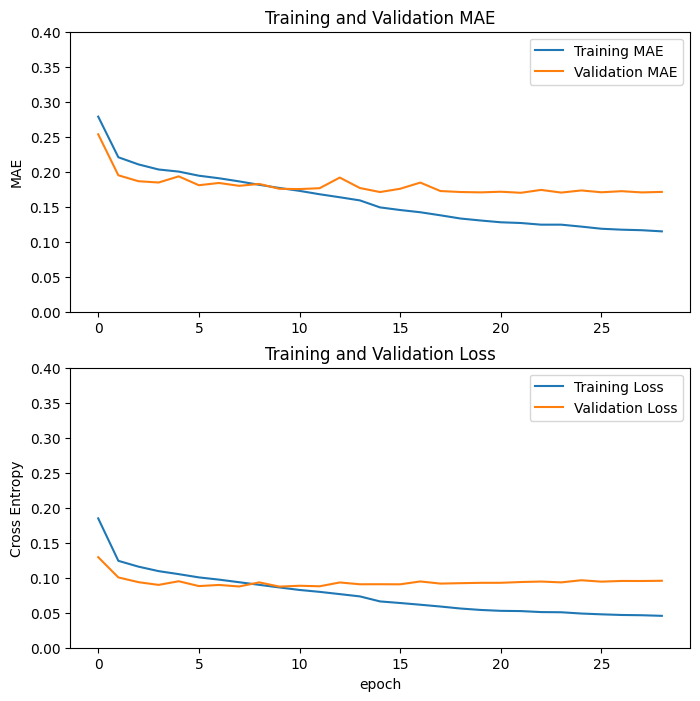

In [35]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.ylabel('MAE')
plt.ylim([0, 0.4])
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 0.4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 0s 31ms/step
[[0.9756619 0.9999932]]
[1.        0.9921875]


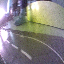

In [55]:
idx = 1000

print(model.predict(X_test[idx][np.newaxis, ...]))
print(y_test[idx])
Image.fromarray(np.asarray(X_test[idx] * 255).astype(np.uint8))

In [56]:
final_mae = model.evaluate(X_test, y_test)[1]

72/72 [==============================] - 1s 13ms/step - loss: 0.0939 - mae: 0.1699


In [57]:
model.save(f"./models/model_{final_mae:0.3f}")

INFO:tensorflow:Assets written to: ./models/model_0.170\assets


INFO:tensorflow:Assets written to: ./models/model_0.170\assets


In [58]:
spec = (tf.TensorSpec((None, 64, 64, 3), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=11,
                                            output_path=f"onnx/model_{final_mae:0.3f}.onnx")